In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import scipy.optimize

In [2]:
#using rotvec format, can provide angle*axis vector as a single argument
#the from_rotvec method creates the rotation object, which can then be used in other formats (rotation matrix)
#thus just need to define the correct rotation axis
r = R.from_rotvec((-np.pi/2)*np.array([0,1,0]))  # - rotation of vector in x, into z (e.g. around y-axis [0,1,0])
vec = np.array([1,0,0])
# np.dot(vec, vec*r.as_rotvec())
rotated = r.apply(vec)
inverse = r.apply(rotated, inverse=True)
print(vec, rotated, inverse)

[1 0 0] [2.22044605e-16 0.00000000e+00 1.00000000e+00] [1. 0. 0.]


In [8]:
#basic idea of approach: rotating to remove tilt
#the tilt causes the scale at surface level to be dominated by the peak-valley height
#so essentially want to reduce the peak-valley height to a minimum -> optimisation
#define a function which operates combined x & y rotations on the surface (interpolated?) and returns peak-valley height
#then use scipy optimise with the function
#I believe the optimisation can work with generic functions so long as the input and outputs fit certain requirements
#set up function to take the array values (create a surface from them ?), and also initial angles to attempt (leave as 0 ?)
#how does optimize work with parameters into f vs into optimize itself?

In [3]:
#assuming an input array with grid of heights
#to be converted into position vectors from the i,j index and value, i.e. [x=i,y=j,z=value]
#will probably change to more general co-ordinates centred at (0,0) rather than only in the positive plane
#need more than the heights to rotate but only want to extract the height for easy peak-valley calculation
def testf(*args):
    angx, angy = args[0]
    array = args[1]
    dims = array.shape
    x,y = np.indices(dims)
        
    #define rotations in x and y respectively and combine with * operation
    rx = R.from_rotvec(angx*np.array([1,0,0]))
    ry = R.from_rotvec(angy*np.array([0,1,0]))
    r = rx*ry
    
    #make the array of position vectors in (Nx3) format: i.e. [x,y,height] as one element
    vectarray = np.dstack([x,y,array])
    vectarray = vectarray.reshape(int(vectarray.size/3), 3)
    
    #apply overall rotation to the entire vector array (rotates each vector individually)
    #then extract back the individual columns and store them with the original array shape
    newarray = r.apply(vectarray)
    xs = newarray[:,0].reshape(dims)
    ys = newarray[:,1].reshape(dims)
    zs = newarray[:,2].reshape(dims)
    
    peakvalley = np.nanmax(zs) - np.nanmin(zs)
    
    
    
#     print(angx,angy)
#     print("\t",np.argmax(heights),np.argmin(heights))
    
    return peakvalley

In [87]:
e = np.random.rand(100,143)
print(e)

testf([0,-np.pi/2], e)

[[0.55676939 0.38154788 0.72811968 ... 0.18677536 0.33077371 0.43354742]
 [0.15060127 0.45478376 0.08148491 ... 0.00847105 0.98450223 0.97200681]
 [0.0600198  0.96821272 0.32114207 ... 0.29837548 0.9985046  0.83911635]
 ...
 [0.60451485 0.49168364 0.98643304 ... 0.73324224 0.95856028 0.38473627]
 [0.44922671 0.23448988 0.7529539  ... 0.42564145 0.5273437  0.66832544]
 [0.98313329 0.30565406 0.57905308 ... 0.19846619 0.0203315  0.47277194]]


99.0

In [4]:
arr = np.array([[0,0,0],[1,1,1],[2,2,2]])
# arr = np.random.rand(100,143)
opts = {"ftol":1e-12, "xtol":1e-12, "maxiter":1000}
params = scipy.optimize.minimize(testf, x0=[0,0], args=arr, tol=1e-15, method="Nelder-Mead", options=opts)
optimalangles = params["x"]
params

 final_simplex: (array([[-1.36978800e-17,  7.85398163e-01],
       [ 2.20714368e-16,  7.85398163e-01],
       [ 5.20297696e-16,  7.85398163e-01]]), array([6.93529575e-16, 8.85517945e-16, 1.11022302e-15]))
           fun: 6.935295747998653e-16
       message: 'Optimization terminated successfully.'
          nfev: 313
           nit: 161
        status: 0
       success: True
             x: array([-1.36978800e-17,  7.85398163e-01])

In [11]:
scipy.optimize.brute(testf, ranges=(slice(0,90),slice(0,90)), args=arr)

ValueError: not enough values to unpack (expected 2, got 1)

In [81]:
#minimize doesn't allow a set range to be given, so limited testing
#need to figure out how to pass an array to the function
#since optimising methods expect f(x, *args) and x would be the angles in this case
#but still need the array passed through
e = np.random.rand(3,3)
# print(e)
# params = scipy.optimize.minimize(testf, x0=[np.pi/4,-np.pi/2], args=e, tol=1e-5)
# params
# params = scipy.optimize.brute(testf, ranges=[(0,-np.pi/2),(0,-np.pi/2)], args=(e), full_output=True)
params

      fun: 0.6551885824706932
 hess_inv: array([[ 0.02210231, -0.02163904],
       [-0.02163904,  0.30366908]])
      jac: array([-0.14072432,  0.87104756])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 198
      nit: 2
     njev: 62
   status: 2
  success: False
        x: array([-0.04624033, -0.06277981])

In [114]:
f = lambda x: x**2 + 3
params = scipy.optimize.brute(f, ranges=[(-5,5)], full_output=True)
params

(array([-2.22044605e-16]),
 3.0,
 array([-5.        , -4.47368421, -3.94736842, -3.42105263, -2.89473684,
        -2.36842105, -1.84210526, -1.31578947, -0.78947368, -0.26315789,
         0.26315789,  0.78947368,  1.31578947,  1.84210526,  2.36842105,
         2.89473684,  3.42105263,  3.94736842,  4.47368421,  5.        ]),
 array([28.        , 23.01385042, 18.58171745, 14.70360111, 11.37950139,
         8.60941828,  6.3933518 ,  4.73130194,  3.6232687 ,  3.06925208,
         3.06925208,  3.6232687 ,  4.73130194,  6.3933518 ,  8.60941828,
        11.37950139, 14.70360111, 18.58171745, 23.01385042, 28.        ]))

In [11]:
scipy.optimize.minimize

<function scipy.optimize._minimize.minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)>

In [118]:
#with an array of vectors [x,y,z] at each i,j co-ordinate, the rotation can only be applied to the individual vectors
#so should be reshaped into one vector per row (i.e. Nx3 array) and then applied onto the reshaped array
#then reshape back to the first instance
o = np.array([[[1,0,0],[0,1,0],[0,0,1]], [[0,1,0],[0,0,1],[1,0,0]], [[0,0,1],[1,0,0],[0,1,0]]])
print(o)
o = o.reshape(9,3)
# print(o)
p = np.around(r.apply(o), 2)
print(p)
# p = p.reshape(3,3,3)

#i,jth element is rotated
# print(p[0][0])

[[[1 0 0]
  [0 1 0]
  [0 0 1]]

 [[0 1 0]
  [0 0 1]
  [1 0 0]]

 [[0 0 1]
  [1 0 0]
  [0 1 0]]]
[[ 1.  0.  0.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 0.  1. -0.]]


In [119]:
p[:,-1].reshape(3,3)

array([[ 0., -0.,  1.],
       [-0.,  1.,  0.],
       [ 1.,  0., -0.]])

In [3]:
#better way to arrange heights at positions into vectors which can be rotated
#using indices - gives arrays containing i,j numbers in increasing order
#these can be used for grid since i,j corresponds here to actual position on graph (might have to change to general co-ords)
#form vectors grid using dstack with the row index (x array), column index (y array), and array value at each point (arr array)
#reshaped into Nx3 array, with vectors [i,j,arr] with i,j giving position and arr the height at that position
#then this form can be directly rotated using r.apply and reshaped afterwards
#can then extract back into x,y,z seperate data to be plotted
arr = np.array([[0,0,0],[1,1,1],[2,2,2]])
dims = arr.shape
x,y = np.indices(dims)
# X,Y = np.arange(0, dims[0]), np.arange(0, dims[1])
# x,y = np.meshgrid(X,Y, indexing="ij")

# grid1 = np.array([np.array([x[i,j],y[i,j],arr[i,j]]) for i in range(arr.shape[0]) for j in range(arr.shape[1])])
grid2 = np.dstack([x,y,arr])
grid2 = grid2.reshape(int(grid2.size/3),3)
grid2

array([[0, 0, 0],
       [0, 1, 0],
       [0, 2, 0],
       [1, 0, 1],
       [1, 1, 1],
       [1, 2, 1],
       [2, 0, 2],
       [2, 1, 2],
       [2, 2, 2]])

In [163]:
angx,angy = optimalangles
rotx = R.from_rotvec(angx*np.array([1,0,0]))
roty = R.from_rotvec(angy*np.array([0,1,0]))
rot = rotx*roty
grid = rot.apply(grid2)
xs = grid[:,0].reshape(dims)
ys = grid[:,1].reshape(dims)
zs = grid[:,2].reshape(dims)
print(np.nanmax(zs) - np.nanmin(zs))

grid

6.935295747998653e-16


array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00, -1.36978800e-17],
       [ 0.00000000e+00,  2.00000000e+00, -2.73957600e-17],
       [ 1.41421356e+00,  4.62223187e-33,  3.33066907e-16],
       [ 1.41421356e+00,  1.00000000e+00,  3.33066907e-16],
       [ 1.41421356e+00,  2.00000000e+00,  3.33066907e-16],
       [ 2.82842712e+00,  9.24446373e-33,  6.66133815e-16],
       [ 2.82842712e+00,  1.00000000e+00,  6.66133815e-16],
       [ 2.82842712e+00,  2.00000000e+00,  6.66133815e-16]])

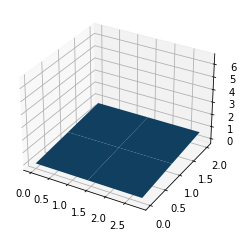

In [164]:
fig = plt.figure()

ax = fig.add_subplot(111, projection="3d")
# ax.set_xlim(-2,2)
# ax.set_ylim(-2,2)
ax.set_zlim(10*np.nanmin(zs),10*np.nanmax(zs))
p = ax.plot_surface(xs,ys,zs.T)
plt.show()

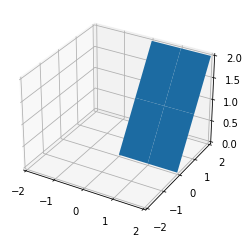

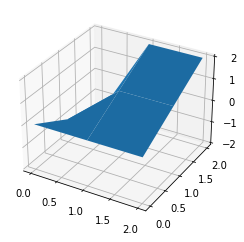

In [33]:

rot = R.from_rotvec(np.pi/2*np.array([0,0,1]))

X,Y = np.arange(0,arr.shape[0]), np.arange(0, arr.shape[1])
x,y = np.meshgrid(X,Y)

fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection="3d")
ax1.set_xlim(-2,2)
ax1.set_ylim(-2,2)
# ax1.set_zlim(-2,2)
p = ax1.plot_surface(x,y, arr)

plt.show()

fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection="3d")
q = ax2.plot_surface(x,y, rot.apply(arr))

plt.show()